# Web Scraping

## The Lab:
1. Pick something else on Craigslist besides used cars: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of basic EDA you'd do with it.
2. Get your search results of interest using requests and extract data from them using beautifulSoup, using code similar to what's above.
3. Wrangle your data into a dataframe and do some basic descriptions and plots. Try to find some interesting relationships or stories to tell about your data.

Charlottesville Bikes for Sale
https://charlottesville.craigslist.org/search/bia#search=1~gallery~0~0
What types of bikes are for sale? How expensive are they? What is the most common use of the bikes for sale? Are the meant for mountains or children?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'} # How we wish to appear to CL
url = 'https://charlottesville.craigslist.org/search/bia#search=1~gallery~0~30' # The page we want to scrape
raw = requests.get(url,headers=header) # Get page

In [2]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings of the kind we want

In [3]:
import re # Regular expressions
# Define bike types
types = ['mountain', 'kids', 'hybrid', 'electric', 'bmx', 'folding', 'cruiser', 'touring', 'recumbent', 
         'tandem', 'fixie']
# Extract data
data = []
for k in range(len(listings)):
    title = listings[k].find('div', class_='title').get_text().lower()
    price_elem = listings[k].find('div', class_='price')
    link_elem = listings[k].find(href=True)
    
    price = price_elem.get_text() if price_elem else 'missing'
    link = link_elem['href'] if link_elem else 'missing'
    
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title)
    year = regex_search.group(0) if regex_search else np.nan
    
    words = title.split()
        
    hits_type = [word for word in words if word in types]
    bike_type = hits_type[0] if hits_type else 'unknown'
    
    wheel_size_search = re.search(r'\b(20|24|26|27.5|29)\b', title)
    wheel_size = wheel_size_search.group(0) if wheel_size_search else 'unknown'
    
    data.append({'title': title, 'price': price, 'year': year, 'link': link, 'bike_type': bike_type, 'wheel_size': wheel_size})

In [5]:
# Convert to DataFrame
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$', '').str.replace(',', '')
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df['age'] = 2025 - df['year']
print(df.shape)
df.to_csv('craigslist_bikes.csv', index=False)
df.head()

(41, 7)


,title,price,year,link,bike_type,wheel_size,age
0,2024 hyper wizard custom bmx build,2400,2024.0,https://charlottesville.craigslist.org/bik/d/c...,bmx,unknown,1.0
1,giant roam 2 bicycle,190,NaN,https://charlottesville.craigslist.org/bik/d/c...,unknown,unknown,NaN
2,1985 panasonic team america vintage bike w/dur...,450,1985.0,https://charlottesville.craigslist.org/bik/d/c...,unknown,unknown,40.0
3,2 trek navigator 200 mountain bikes,250,NaN,https://charlottesville.craigslist.org/bik/d/m...,mountain,unknown,NaN
4,"garneau gros louis 2 fat tire bike - $1,200 obo",1200,NaN,https://charlottesville.craigslist.org/bik/d/c...,unknown,unknown,NaN


             price         year        age
count    41.000000     7.000000   7.000000
mean    674.097561  2014.714286  10.285714
std     895.490000    13.511900  13.511900
min      20.000000  1985.000000   1.000000
25%      85.000000  2015.500000   3.000000
50%     200.000000  2019.000000   6.000000
75%     900.000000  2022.000000   9.500000
max    4200.000000  2024.000000  40.000000


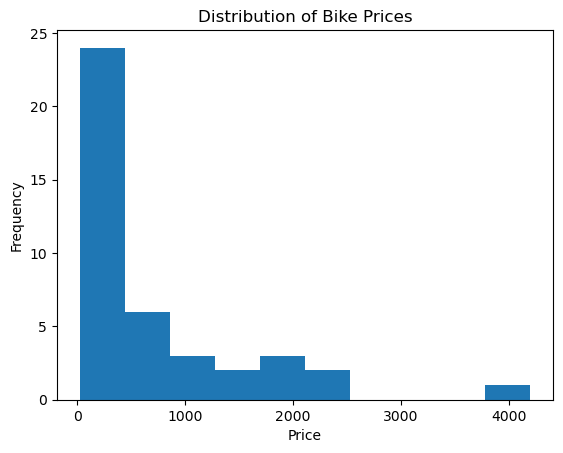

In [6]:
print(df.describe())

df['price'].hist(grid=False)
plt.title("Distribution of Bike Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

             price         year        age
count    41.000000     7.000000   7.000000
mean    674.097561  2014.714286  10.285714
std     895.490000    13.511900  13.511900
min      20.000000  1985.000000   1.000000
25%      85.000000  2015.500000   3.000000
50%     200.000000  2019.000000   6.000000
75%     900.000000  2022.000000   9.500000
max    4200.000000  2024.000000  40.000000


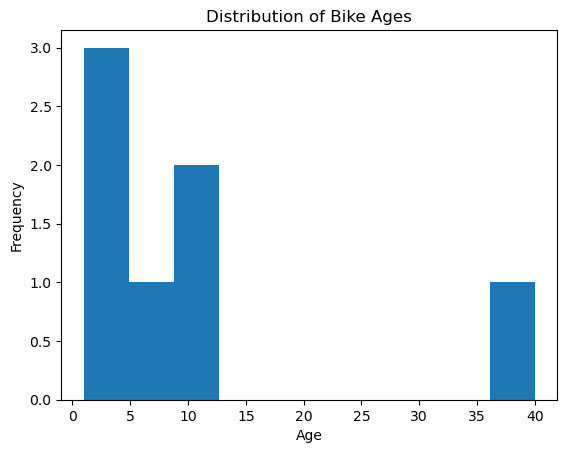

In [9]:
print(df.describe())
df['age'].hist(grid=False)
plt.title("Distribution of Bike Ages")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

In [17]:
# Price by type of bike:
(df.loc[:,['price','bike_type']].groupby('bike_type').describe())

price                                                           \
          count         mean         std     min     25%     50%     75%   
bike_type                                                                  
bmx         1.0  2400.000000         NaN  2400.0  2400.0  2400.0  2400.0   
cruiser     2.0    60.000000    0.000000    60.0    60.0    60.0    60.0   
electric    1.0   750.000000         NaN   750.0   750.0   750.0   750.0   
kids        2.0    95.000000   77.781746    40.0    67.5    95.0   122.5   
mountain    7.0   594.285714  771.429563    50.0    80.0   250.0   750.0   
unknown    28.0   714.928571  942.783740    20.0   100.0   212.5  1050.0   

                   
              max  
bike_type          
bmx        2400.0  
cruiser      60.0  
electric    750.0  
kids        150.0  
mountain   2200.0  
unknown    4200.0

In [18]:
# Age by type of bike:
df.loc[:,['age','bike_type']].groupby('bike_type').describe()

age                                                  
          count       mean        std  min   25%  50%   75%   max
bike_type                                                        
bmx         1.0   1.000000        NaN  1.0  1.00  1.0  1.00   1.0
cruiser     0.0        NaN        NaN  NaN   NaN  NaN   NaN   NaN
electric    0.0        NaN        NaN  NaN   NaN  NaN   NaN   NaN
kids        0.0        NaN        NaN  NaN   NaN  NaN   NaN   NaN
mountain    0.0        NaN        NaN  NaN   NaN  NaN   NaN   NaN
unknown     6.0  11.833333  14.105554  3.0  3.75  7.5  9.75  40.0

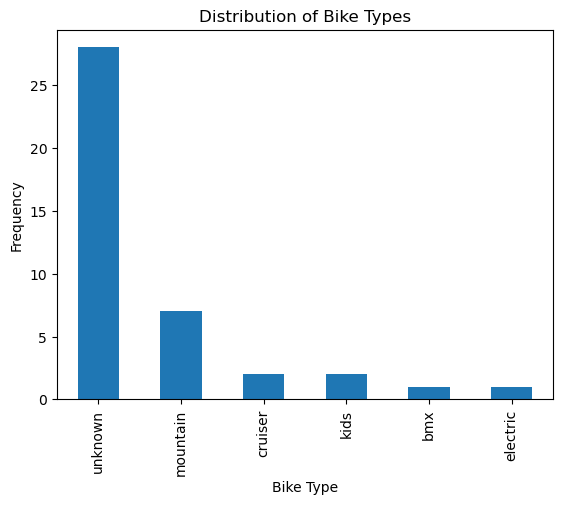

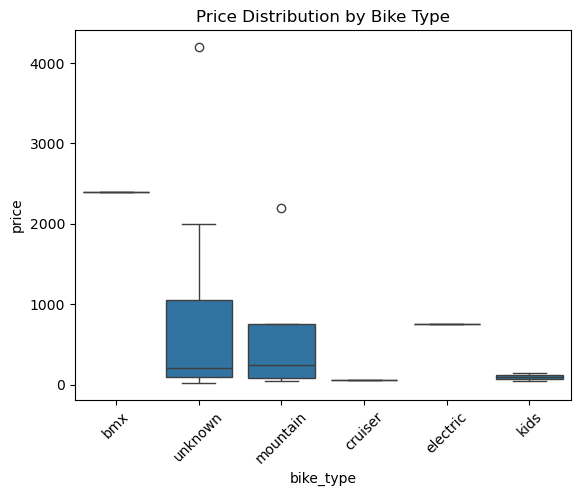

In [10]:
# Bike Type Analysis
type_counts = df['bike_type'].value_counts()
type_counts.plot(kind='bar', grid=False)
plt.title("Distribution of Bike Types")
plt.xlabel("Bike Type")
plt.ylabel("Frequency")
plt.show()

sns.boxplot(data=df, x='bike_type', y='price')
plt.title("Price Distribution by Bike Type")
plt.xticks(rotation=45)
plt.show()

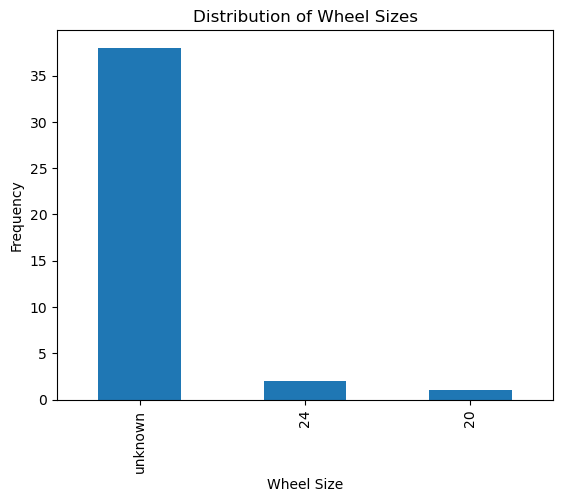

In [11]:
# Wheel Size Analysis
wheel_size_counts = df['wheel_size'].value_counts()
wheel_size_counts.plot(kind='bar', grid=False)
plt.title("Distribution of Wheel Sizes")
plt.xlabel("Wheel Size")
plt.ylabel("Frequency")
plt.show()